In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import ElasticNet, ElasticNetCV, LassoCV, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, RobustScaler, scale, minmax_scale
import seaborn as sns 

In [57]:
####################################### SET CITY VARS HERE ###########################################################

place_abbr = 'cinci'
#place_abbr = 'seattle'
#place_abbr = 'nyc'
#place_abbr = 'houston'
#place_abbr = 'sf'
#place_abbr = 'atlanta'

tracts_deserts_path = 'data/tract_desert_measures/nyc_desert_tracts.csv'

save_data_dir = 'data/tract_health/'
save_data_name =  place_abbr+'_tract_health.csv'
save_transf_data_name =  place_abbr+'_tract_health_logt.csv'

save_regression_path = 'data/tract_health/results/'
save_lasso_name = place_abbr+'_tract_lasso_results'

# Aggregation/Cleaning

In [58]:
tracts_deserts = pd.read_csv(tracts_deserts_path, dtype={'GEOID':'str'})
tracts_deserts = tracts_deserts.rename(columns={'GEOID':'TractFIPS'})

In [59]:
tracts_health = pd.read_csv("data/PLACES__Census_Tract_Data__GIS_Friendly_Format___2021_release.csv", dtype={'TractFIPS':'str'})
tracts_health = pd.merge(tracts_health, tracts_deserts, on='TractFIPS')

income_vars = pd.read_csv('data/tract_incomevars.csv', dtype=str).astype({'PovertyRate':'float', 'TractFIPS':'str'})
tracts_health = pd.merge(tracts_health, income_vars, on='TractFIPS')

tracts_health.to_csv(save_data_dir+save_data_name, index=False)

In [60]:
desert_measures = ['food_closest_travel_times', 'physical_closest_dist', 'transport_closest_dist', 'education_closest_travel_times', 'worship_closest_travel_times']

tracts_health_logt = tracts_health.copy()
tracts_health_logt[desert_measures] = tracts_health_logt[desert_measures].apply(lambda x: np.log(x+1))
tracts_health_logt.to_csv(save_data_dir + save_transf_data_name, index=False)

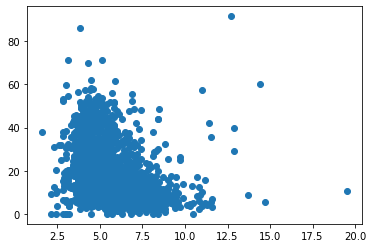

In [63]:
plt.scatter(tracts_health.CANCER_CrudePrev, tracts_health.PovertyRate, size=)

# Analysis

In [43]:
name_mapping = {'access2': 'Health insurance access', 'arthritis': 'Arthritis prevalence', 'binge': 'Binge drinking prevalence',
               'bphigh': 'High blood pressure prevalence', 'bpmed': 'Medium blood pressure prevalence', 'cancer': 'Cancer prevalence',
               'casthma': 'Asthma prevalence', 'cervical': 'Cervical cancer screenings', 'chd': 'Coronary heart disease prevalence',
               'checkup': 'Routine checkups', 'cholscreen': 'Cholesterol screenings', 'colon_screen': 'Colon cancer screenings',
               'copd': 'COPD prevalence', 'corem': 'Core men\'s health', 'corew': 'Core women\'s health', 'csmoking': 'Smoking prevalence',
               'dental': 'Dental checkups', 'depression': 'Depression prevalence', 'diabetes': 'Diabetes prevalence', 'ghlth': 'General poor health prevalence',
               'highchol': 'High cholesterol prevalence', 'kidney': 'Chronic kidney disease', 'lpa': 'No physical activity', 'mammouse': 'Mammograms',
               'mhlth': 'Poor mental health prevalence', 'obesity': 'Obesity prevalence', 'phlth': 'Poor physical health', 'sleep': 'Poor sleep prevalence',
               'stroke': 'Stroke prevalence', 'teethlost': 'Teeth loss prevalence'}

results_all_nan = pd.DataFrame({'Health condition': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 'Food': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')],
                       'Physical health': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 'Public transport': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')],
                        'Education': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 'Houses of worship': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')],
                       'Poverty Rate': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 'RSquared': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 
                            'MSE': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')]})
results_nan = pd.DataFrame({'Health condition': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 'Food': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')],
                       'Physical health': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 'Poverty Rate': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 
                            'RSquared': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')], 
                            'MSE': [np.nan for c in tracts_health.columns if c.endswith('CrudePrev')]})
add_vars = ['PovertyRate']

In [44]:
def update_all_vars():
        results.iat[i, 0] = name
        results.iat[i, 1] = regr.coef_[0]
        results.iat[i, 2] = regr.coef_[1]
        results.iat[i, 3] = regr.coef_[2]
        results.iat[i, 4] = regr.coef_[3]
        results.iat[i, 5] = regr.coef_[4]
        results.iat[i, 6] = regr.coef_[5]
        results.iat[i, 7] = regr.score(X_test, y_test)
        results.iat[i, 8] = mse_test
def update_vars():
        results.iat[i, 0] = name
        results.iat[i, 1] = regr.coef_[0]
        results.iat[i, 2] = regr.coef_[1]
        results.iat[i, 3] = regr.coef_[2]
        results.iat[i, 4] = regr.score(X_test, y_test)
        results.iat[i, 5] = mse_test

## Run LASSO regression:
- For all deserts types; *all_deserts = True*
- Food and physical activity deserts only; *all_deserts = False*
- With log transformed desert measures; *log_transf = True*
- Without log transformed desert measures; *log_transf = False*

In [45]:
#set desert and log transformation params
all_deserts=True
log_transf = False

In [66]:
np.mean(y)

-2.687632097437731e-16

In [64]:
if all_deserts == True:
    desert_measures = ['food_closest_travel_times', 'physical_closest_dist', 'transport_closest_dist', 'education_closest_travel_times', 'worship_closest_travel_times']
    results = results_all_nan.copy()
    update_method = update_all_vars
else:
    desert_measures = ['food_closest_travel_times', 'physical_closest_dist']
    results = results_nan.copy()
    update_method = update_vars
if log_transf == True:
    df = tracts_health_logt
else:
    df = tracts_health
alphas = []
l1_ratios = []
i=0


for c in df.columns:
    if c.endswith('CrudePrev'):
        name = name_mapping[c[:-10].lower()]
        
        x = df[desert_measures+add_vars].to_numpy(copy=True)
        scaler = StandardScaler()
        xscale = scaler.fit_transform(x)
        
        y = df[c].to_numpy(copy=True)
        
        xscale = xscale[~np.isnan(y)]
        
        y = scale(y[~np.isnan(y)])
        center_function = lambda x: x - x.mean()
        y = center_function(y)
        
        X_train, X_test, y_train, y_test = train_test_split(xscale, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)
        
        lasso_cv = LassoCV(cv = 5, normalize=True).fit(X_train,y_train)
        
        alpha = lasso_cv.alpha_
        alphas.append(alpha)
        
        regr = Lasso(alpha=alpha, normalize=True)
        regr.fit(X_train, y_train.reshape(-1, 1))
        
        predictions = regr.predict(X_test)
        y_train_pred = regr.predict(X_train)
        mse_test = mean_squared_error(y_test, predictions)
        
        if all_deserts==True:
            update_all_vars()
        else:
            update_vars()

        i += 1

results_round = results.round({'Food': 4, 'Physical health':4, 'Public transport':4, 'Education':4,
             'House of worship':4, 'RSquared':4})
results_round.sort_values(by='MSE').reset_index(drop=True)

,Health condition,Food,Physical health,Public transport,Education,Houses of worship,Poverty Rate,RSquared,MSE
0,Teeth loss prevalence,0.0432,0.1175,0.0476,-0.0033,-0.005547,0.846107,0.7223,0.263635
1,Poor mental health prevalence,0.0611,0.0626,0.0328,-0.0000,0.012418,0.855716,0.6959,0.314783
2,Poor physical health,0.0622,0.0846,0.0737,-0.0000,0.028284,0.819483,0.6919,0.322835
3,General poor health prevalence,0.0599,0.0754,0.0387,0.0021,-0.000000,0.806284,0.6621,0.353995
4,Smoking prevalence,0.0956,0.1093,0.0617,-0.0000,0.026940,0.794979,0.6525,0.370467
5,Dental checkups,-0.0123,-0.1264,-0.0205,-0.0182,0.003441,-0.783416,0.6212,0.393650
6,No physical activity,0.0868,0.1286,0.0664,0.0099,0.000000,0.750344,0.5657,0.445537
7,Core women's health,0.0426,-0.1453,-0.0015,-0.0229,0.055766,-0.712862,0.4769,0.481928
8,Colon cancer screenings,0.0000,-0.0892,-0.0084,-0.0197,-0.000031,-0.727641,0.5300,0.487004
9,Health insurance access,-0.0000,0.0602,-0.0000,0.0253,-0.024733,0.746161,0.5294,0.495366


## LASSO on Whole Dataset

In [54]:
#set desert and log transformation params
all_deserts=True
log_transf = False

In [55]:
if all_deserts == True:
    desert_measures = ['food_closest_travel_times', 'physical_closest_dist', 'transport_closest_dist', 'education_closest_travel_times', 'worship_closest_travel_times']
    results = results_all_nan.copy()
    update_method = update_all_vars
else:
    desert_measures = ['food_closest_travel_times', 'physical_closest_dist']
    results = results_nan.copy()
    update_method = update_vars
if log_transf == True:
    df = tracts_health_logt
else:
    df = tracts_health
alphas = []
l1_ratios = []
i=0


for c in df.columns:
    if c.endswith('CrudePrev'):
        name = name_mapping[c[:-10].lower()]
        
        x = df[desert_measures+add_vars].to_numpy(copy=True)
        scaler = StandardScaler()
        xscale = scaler.fit_transform(x)
        y = df[c].to_numpy(copy=True)
        xscale = xscale[~np.isnan(y)]
        y = scale(y[~np.isnan(y)])
        #create function to center data
        center_function = lambda x: x - x.mean()

        #apply function to original NumPy array
        y = center_function(y)
        
        X_train, X_test, y_train, y_test = train_test_split(xscale, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)
        
        #l1 ratio is from suggested values in ElasticNetCV documentation
        lasso_cv = LassoCV(cv = 5, normalize=True).fit(X_train,y_train)
        
        alpha = lasso_cv.alpha_
        alphas.append(alpha)
        
        regr = Lasso(alpha=alpha, normalize=True)  # Could try others, or other parameters?
        regr.fit(xscale, y.reshape(-1, 1))
        
        predictions = regr.predict(xscale)
        mse_test = mean_squared_error(y, predictions)
        
        if all_deserts==True:
            update_all_vars()
        else:
            update_vars()

        i += 1

results_round = results.round({'Food': 4, 'Physical health':4, 'Public transport':4, 'Education':4,
             'House of worship':4, 'RSquared':4})
results_round.sort_values(by='MSE').reset_index(drop=True)

,Health condition,Food,Physical health,Public transport,Education,Houses of worship,Poverty Rate,RSquared,MSE
0,Poor mental health prevalence,0.0665,0.0619,0.0231,-0.0048,0.017630,0.838188,0.6979,0.286967
1,Teeth loss prevalence,0.0451,0.1135,0.0444,-0.0000,-0.000000,0.836554,0.7230,0.303490
2,Poor physical health,0.0675,0.0710,0.0733,-0.0000,0.014951,0.815934,0.6931,0.331081
3,Smoking prevalence,0.0980,0.1042,0.0547,-0.0000,0.034150,0.789892,0.6530,0.350883
4,General poor health prevalence,0.0609,0.0628,0.0343,0.0000,-0.000000,0.799566,0.6629,0.351900
5,Dental checkups,-0.0045,-0.1107,-0.0157,-0.0060,0.002058,-0.775692,0.6236,0.397075
6,No physical activity,0.0833,0.1152,0.0670,0.0000,0.000000,0.740340,0.5670,0.438716
7,Health insurance access,0.0000,0.0543,-0.0004,0.0143,-0.022690,0.731105,0.5304,0.457761
8,Colon cancer screenings,0.0000,-0.0863,-0.0029,-0.0082,-0.000000,-0.714310,0.5303,0.475519
9,Core women's health,0.0348,-0.1302,-0.0000,-0.0073,0.056751,-0.694570,0.4789,0.506086


### Save Output:

In [56]:
if all_deserts == True:
    save_lasso_name_ = save_lasso_name + '_all'
else:
    save_lasso_name_ = save_lasso_name
if log_transf == True:
    save_lasso_name_ = save_lasso_name + '_logt'
else:
    save_lasso_name_ = save_lasso_name
results_round.to_csv(save_regression_path+save_lasso_name_+'.csv', index=False)